Evan Edelstein
EN.605.645.82.SP26

In [1]:
%matplotlib inline

# Module 3 - Programming Assignment

## General Directions

1. You must follow the Programming Requirements outlined on Canvas.
2. The Notebook should be cleanly and fully executed before submission.
3. You should change the name of this file to be your JHED id. For example, `jsmith299.ipynb` although Canvas may change it to something else...and that's ok.

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Important</strong>
    <p>
        You should always read the entire assignment before beginning your work, so that you know in advance what the requested output will be and can plan your implementation accordingly.
    </p>
</div>

<div style="color: white; background: #C83F49; margin:20px; padding: 20px;">
    <strong>Academic Integrity and Copyright</strong>
    <p>You are not permitted to consult outside sources (Stackoverflow, YouTube, ChatGPT, etc.) or use "code assistance" (Co-Pilot, etc) to complete this assignment. By submitting this assignment for grading, you certify that the submission is 100% your own work, based on course materials, group interactions, instructor guidance. You agree to comply by the requirements set forth in the Syllabus, including, by reference, the JHU KSAS/WSE Graduate Academic Misconduct Policy.</p>
    <p>Sharing this assignment either directly (e.g., email, github, homework site) or indirectly (e.g., ChatGPT, machine learning platform) is a violation of the copyright. Additionally, all such sharing is a violation the Graduate Academic Misconduct Policy (facilitating academic dishonesty is itself academic dishonesty), even after you graduate.</p>
    <p>If you have questions or if you're unsure about the policy, ask via Canvas Inbox. In this case, being forgiven is <strong>not</strong> easier than getting permission and ignorance is not an exuse.</p>
    <p>This assignment is copyright (&copy Johns Hopkins University &amp; Stephyn G. W. Butcher). All rights reserved.</p>
</div>

# The Problem

When we last left our agent in Module 1, it was wandering around a world filled with plains, forests, swamps, hills and mountains. This presupposes a map with known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it might it could see something like this:

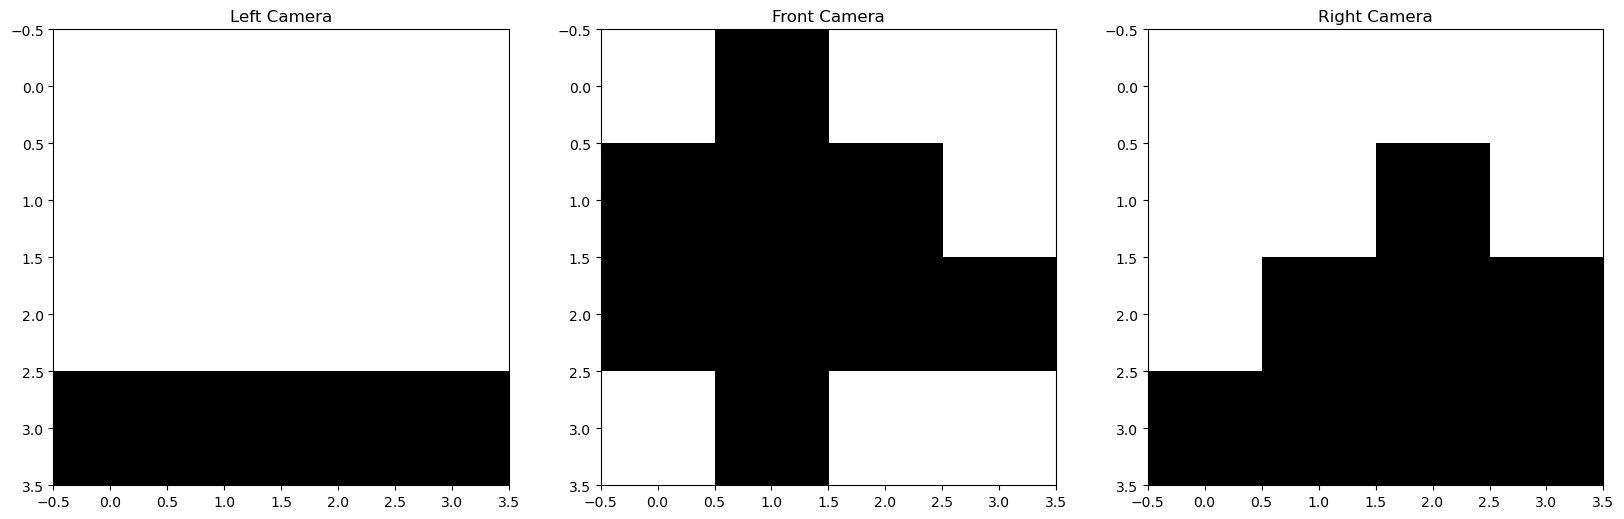

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

which would be plains, forest and hills respectively.

## The Assignment

For this programming assignment your tasks are:

1. Write a logistic regression that simply determines if something is a hill or not (two class problem). 
2. You will also evaluate that logistic regression by generating a *confusion matrix*.

For a starting point, refer to the Pseudocode and the Self-Check.

## Data

We have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often noisy.

Here are the clean examples with different registrations: 

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
def view_sensor_image(data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

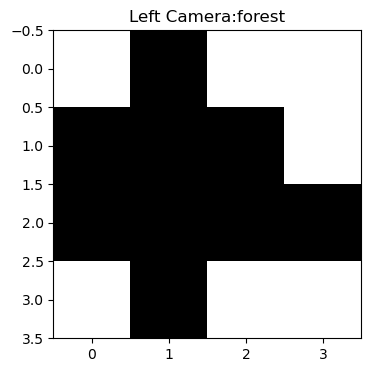

In [5]:
view_sensor_image( clean_data[ "forest"][0])

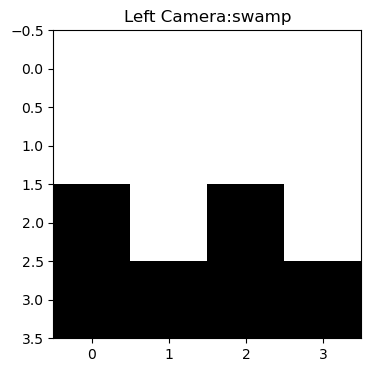

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values that should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss(0.30, 0.07) # (0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss(0.70, 0.07) # (0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

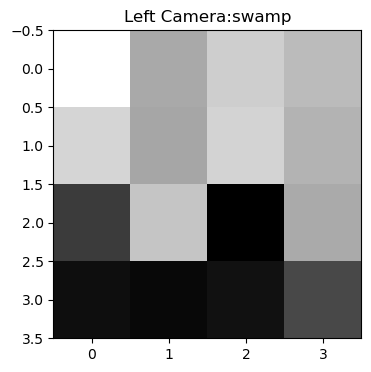

In [8]:
view_sensor_image(blur(clean_data["swamp"][0]))

We need four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`
4. `evaluate`

### generate_data

`generate_data` has been written for you.

* clean_data - the clean versions of the "bitmaps" for each of the terrain types
* n - the number of samples for "in the class" (1) and "not in the class" (0) to generate.
* label - the label to chose as "in the class".

For example,

`generate_data( clean_data, 100, "hills")`

generates 100 hills, 100 not hills and has transformed the String labels into 1 and 0, respectively.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the logistic regression model.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

For this problem, an `epsilon` of 1e-5 is a good balance between accuracy and time to convergence. Additionally, it'll make sure we all generally get the same results. You should start with an `alpha` of 0.1 and then make it adaptive as described in the Pseudocode.

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You don't need to run it to convergence...you'll know pretty quickly if you're doing the right thing. When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the List of Thetas.

### `apply_model`

`apply_model` takes a List of Thetas (the model) and lableled data. You will return a List of Tuples. Each Tuple will contain the actual $y$ value and the predicted y value ($\hat{y}) as the probability.

### `evaluate`

Ideally, we should be doing the model evaluation things we learned this module. Instead, we're just going to print out:

1. the error rate
2. a confusion matrix.

```
{"TN": 0, "TP": 0, "FN": 0, "FP": 0}
```
The main reason we're not going to do more is that the full 5x2 cross validation, validation curves, learning curves approach to model evaluation would take too long with this algorithm (at least as an assignment). In the real world, you would just have to bite the bullet and do it although the algorithm could be run in parallel and the results combined.

We will ask you to do these things on later assignments so be prepared.

**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you want.**

---

Put your helper functions above here.

## Main Functions

Use `generate_data` to generate a balanced set of blurred "hills" and "not-hills" examples to test that the function is working.

In [9]:
def generate_data( data, n, key_label):
    labels = list(data.keys())
    labels.remove(key_label)

    total_labels = len(labels)
    result = []
    # create n "not label" and code as y=0
    count = 1
    while count <= n:
        label = labels[count % total_labels]
        datum = blur(random.choice(data[label]))
        xs = datum[0:-1]
        result.append((xs, 0))
        count += 1

    # create n "label" and code as y=1
    for _ in range(n):
        datum = blur(random.choice(data[key_label]))
        xs = datum[0:-1]
        result.append((xs, 1))
    random.shuffle(result)
    return result

In [10]:
results = generate_data( clean_data, 5, "hills")
for result in results:
    print(result)

([0.36808104180394435, 0.3157722203911453, 0.3757729878216203, 0.18833699972226092, 0.3183495958049461, 0.8506502695201341, 0.2927267521280849, 0.3428271774981583, 0.7781582849886359, 0.6000598015267684, 0.5659546879001073, 0.3459626773819638, 0.6663451609041923, 0.7730030424908542, 0.5899498496881672, 0.7974065765051445], 1)
([0.13162601312496092, 0.19696979798039507, 0.31135380361912324, 0.3736378378656939, 0.23731260182374642, 0.3065463069617525, 0.33740037354049573, 0.28516765673656536, 0.7472898778539171, 0.27931070476840975, 0.6610018355188509, 0.288712291495037, 0.6111749332713241, 0.7123047871383177, 0.7219686518454059, 0.8260401479657], 0)
([0.32153219458706234, 0.24786533024491886, 0.2736460939218818, 0.32917945359936396, 0.2923180561428166, 0.35863951450206155, 0.6395980608405885, 0.20747958967145147, 0.3212649483727113, 0.6629398935951689, 0.7194517353336132, 0.7511690875242452, 0.7089539140300561, 0.6855444467766784, 0.7749284641511885, 0.70876540598799], 1)
([0.3676706910

In [11]:
def learn_model(data, verbose=False):
    pass

In [12]:
def apply_model(model, test_data):
    pass

In [13]:
def evaluate(results):
    pass

## Use your code

Use `generate_data` to generate 100 blurred "hills" examples balanced with 100 "non hills" examples and use this as your test data. Print out the first 10 results, one per line.

In [14]:
train_data = generate_data(clean_data, 100, "hills")

In [15]:
test_data = generate_data(clean_data, 100, "hills")

Use `learn_model` to learn a logistic regression model for classifying sensor images as "hills" or "not hills". Use your `generate_data` function to generate a training set of size 100 for "hills". **Set Verbose to True**

In [16]:
model = learn_model( train_data, True)

Apply the model to the test data:

In [17]:
results = apply_model( model, test_data)

Using the results above, print out your error rate (as a percent) and the confusion matrix:

In [18]:
evaluate(results)

## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.